### **Import Libraries**

In [1]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from kafka import KafkaConsumer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

### **Initializing Kafka Consumer**

In [2]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

In [3]:
for m in consumer:
    print(m.value)
    break

b'"\\u00ef\\u00bb\\u00bftimestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack\\n"'


### **Function to get 1000 records from Kafka**

In [4]:
def get_1000_rec(itr):
    list_of_1000_rec = []
    for i, c in enumerate(consumer):
        if i < 1000:
            list_of_1000_rec.append(c.value)
        else:
            break
    print(f"Window {itr}")
    return list_of_1000_rec

### **Loading the Static Dataset**

In [5]:
static_dataset = pd.read_csv("Static_dataset.csv")

### **Function for Feature Engineering and Data Cleaning**

 This function applies various preprocessing steps to the input DataFrame:
 1. Fills missing values in 'longest_word' with the most frequent value (mode).
 2. Converts 'timestamp' to a numerical value representing seconds. If the timestamp is a string in HH:MM:SS format, 
    it's converted to seconds. If the conversion fails or if it's already numeric, it's left as is.
 3. Applies a hashing transformation to 'longest_word' and 'sld' features, and mods the result by 10000 for a consistent range.

In [6]:
def feature_engineering_and_cleaning(df):
    # Handling Missing Values
    df['longest_word'].fillna(df['longest_word'].mode()[0], inplace=True)

    # Timestamp Transformation
    def convert_timestamp(ts):
        if isinstance(ts, str):
            try:
                return sum(float(t) * 60 ** i for i, t in enumerate(reversed(ts.split(':'))))
            except ValueError:
                return 0  # Or handle as appropriate
        else:
            return ts  # Assuming the timestamp is already in seconds if it's not a string

    df['timestamp'] = df['timestamp'].apply(convert_timestamp)

    # Hashing Transformation
    df['longest_word'] = df['longest_word'].apply(lambda x: hash(str(x)) % 10000)
    df['sld'] = df['sld'].apply(lambda x: hash(str(x)) % 10000)

    return df


transformed_data = feature_engineering_and_cleaning(static_dataset)

# Displaying the transformed dataset
transformed_data.head()

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,3379.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2017,8218,14,1,1
1,443.9,27,10,0,10,11,2.767195,6,6,7,3.666667,2017,8218,14,1,1
2,1395.1,26,9,0,10,10,2.742338,6,6,7,3.500000,2017,8218,13,1,0
3,291.9,27,10,0,10,11,2.570417,6,6,7,3.666667,2017,8218,14,1,1
4,764.0,15,9,0,11,0,2.929439,4,3,5,4.333333,5633,5633,15,1,1


### **Load the static and dynamic model**

In [7]:
static_model = pickle.load(open('best_rf_model_chi.pkl', 'rb'))
static_model = static_model.named_steps['randomforestclassifier']

Dynamic_model= pickle.load(open('best_rf_model_chi.pkl', 'rb'))
scaler = Dynamic_model.named_steps['scaler']
random_forest_classifier = Dynamic_model.named_steps['randomforestclassifier']

C:\Users\moahmed hanyy\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\moahmed hanyy\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\moahmed hanyy\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator Ran

### **Retrain Function for Dynamic Model**

In [8]:
# Retrains the given dynamic model on the updated dataset.
def retrain(X, y):
    # Retrain the Random Forest Classifier
    random_forest_classifier.fit(X, y)
    
    return random_forest_classifier


### **Feature names selected by Chi-squared technique**

In [9]:
all_cols =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]
selected_features = ['longest_word','sld','numeric','subdomain_length','FQDN_count','special','labels','upper','lower','subdomain']

### **Lists to store F1 scores**

In [10]:
list_of_f1_dynamic_model = []
list_of_f1_static_model = []

### **Function to Adjust Data from Kafka Stream**

In [11]:
def adjust_data(data):
    # Process raw data from Kafka and convert to DataFrame
    processed_data = [eval(item.decode("UTF-8")).strip().split(",") for item in data]
    df = pd.DataFrame(processed_data, columns=all_cols)
    df = feature_engineering_and_cleaning(df)
    return df

### **Static Dataset for Use in Retraining the Dynamic Model**

In [12]:
training_data = static_dataset.copy()
training_data_y = training_data["Target Attack"].astype(int)
training_data = training_data[selected_features]
training_data

,longest_word,sld,numeric,subdomain_length,FQDN_count,special,labels,upper,lower,subdomain
0,2017,8218,11,10,27,6,6,0,10,1
1,2017,8218,11,10,27,6,6,0,10,1
2,2017,8218,10,9,26,6,6,0,10,1
3,2017,8218,11,10,27,6,6,0,10,1
4,5633,5633,0,9,15,4,3,0,11,1
...,...,...,...,...,...,...,...,...,...,...
268069,331,6883,0,3,18,2,3,0,16,1
268070,2017,8218,11,10,27,6,6,0,10,1
268071,2017,8218,11,10,27,6,6,0,10,1
268072,1937,4943,0,0,16,2,2,0,14,0


### **Convert Data Features into Scaled Format Similar to the Features in the Trained Static Model**

In [13]:
training_data = scaler.transform(training_data)
training_data

array([[0.20174035, 0.82188219, 0.91666667, ..., 0.        , 0.29411765,
        1.        ],
       [0.20174035, 0.82188219, 0.91666667, ..., 0.        , 0.29411765,
        1.        ],
       [0.20174035, 0.82188219, 0.83333333, ..., 0.        , 0.29411765,
        1.        ],
       ...,
       [0.20174035, 0.82188219, 0.91666667, ..., 0.        , 0.29411765,
        1.        ],
       [0.19373875, 0.49434943, 0.        , ..., 0.        , 0.41176471,
        0.        ],
       [0.20174035, 0.82188219, 0.91666667, ..., 0.        , 0.29411765,
        1.        ]])

### **Online Learning Loop for Dynamic Model**

This loop processes batches of data, updates the dynamic model as needed, and compares its performance to the static model.
For each iteration, it:
 1. Retrieves and processes a new batch of 1000 records.
 2. Applies feature engineering and selects the relevant features.
 3. Transforms the features using the pre-fitted scaler.
 4. Makes predictions using both the dynamic and static models and calculates their F1 scores.
 5. If the dynamic model's F1 score falls below 0.85, it is retrained with the new data.
 6. Stores the F1 scores for both models for analysis and compar

In [14]:
# Define a function to print in a formatted manner
def print_formatted(iteration, dynamic_f1, static_f1, action):
    print(f"{'*' * 50}")
    print(f"Iteration: {iteration}")
    print(f"{'-' * 50}")
    print(f"Dynamic Model F1 Score: {dynamic_f1:.4f}")
    print(f"Static Model F1 Score: {static_f1:.4f}")
    print(f"Action Taken: {action}")
    print(f"{'*' * 50}\n")

# Initialize the lists for storing scores
list_of_f1_dynamic_model = []
list_of_f1_static_model = []

for itr in range(1, 265):
    r_dataset = get_1000_rec(itr)
    p_dataset = adjust_data(r_dataset)
    new_dataset = feature_engineering_and_cleaning(p_dataset)
    
    # Select only the important features for X and y
    X = new_dataset[selected_features]
    y = new_dataset["Target Attack"].astype(int)
    
    new_x = scaler.transform(X)
    # new_x = pd.DataFrame(new_x, X.columns)
    # Predict and evaluate with Dynamic model
    Dy_pred = random_forest_classifier.predict(new_x).astype(int)
    D_f1 = f1_score(y, Dy_pred)
    print(f"The F1 Score of Dynamic Model without retrain = {D_f1}")

    # Retrain logic
    if D_f1 < 0.85:  # Threshold for retraining
        concat_training_data = np.concatenate([training_data, new_x], axis=0)
        print("Retraining model on the new data")
        random_forest_classifier = retrain(new_x, y)
        Dy_pred = random_forest_classifier.predict(new_x).astype(int)
        D_f1 = f1_score(y, Dy_pred)
        print(f"The F1 Score of Dynamic Model after retrain = {D_f1}")


    # Update training data
    # training_data = pd.concat([static_dataset, new_dataset])

    # Predict and evaluate with Static model
    Sy_pred = static_model.predict(new_x).astype(int)
    S_f1 = f1_score(y, Sy_pred)
    print(f"The F1 Score of Static Model = {S_f1}")

    # Determine the action taken
    action = 'Model Retrained' if D_f1 < 0.85 else 'No Retraining Required'

    # Store results
    list_of_f1_dynamic_model.append(D_f1)
    list_of_f1_static_model.append(S_f1)
    
    # Print results using the defined function
    print_formatted(itr, D_f1, S_f1, action)

Window 1
The F1 Score of Dynamic Model without retrain = 0.8465266558966076
Retraining model on the new data
The F1 Score of Dynamic Model after retrain = 0.8497576736672051
The F1 Score of Static Model = 0.8465266558966076
**************************************************
Iteration: 1
--------------------------------------------------
Dynamic Model F1 Score: 0.8498
Static Model F1 Score: 0.8465
Action Taken: Model Retrained
**************************************************

Window 2
The F1 Score of Dynamic Model without retrain = 0.8546603475513428
The F1 Score of Static Model = 0.8503562945368172
**************************************************
Iteration: 2
--------------------------------------------------
Dynamic Model F1 Score: 0.8547
Static Model F1 Score: 0.8504
Action Taken: No Retraining Required
**************************************************

Window 3
The F1 Score of Dynamic Model without retrain = 0.8425135764158262
Retraining model on the new data
The F1 Score of Dy

### **Plotting F1 Scores for Dynamic and Static Models**

The plot helps in comparing how the dynamic model's performance evolves with each iteration against the static model's consistent performance.

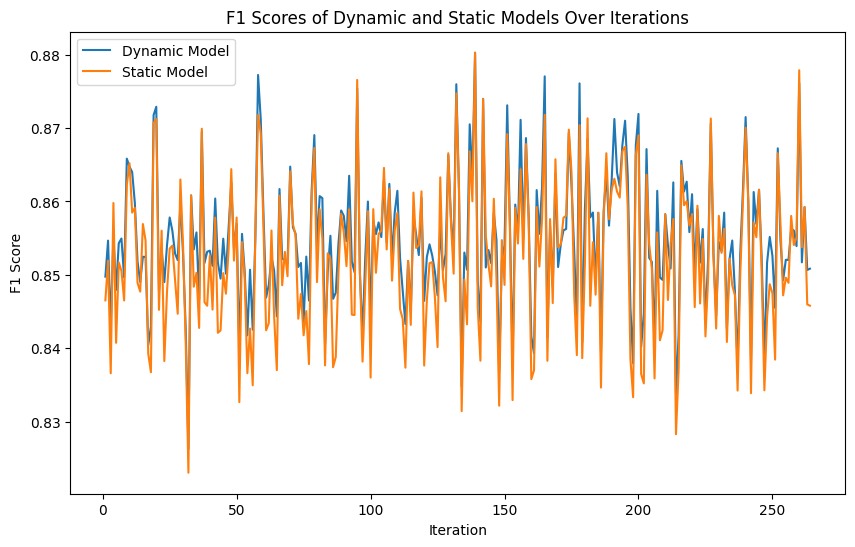

In [16]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, 265), list_of_f1_dynamic_model, label='Dynamic Model')
plt.plot(range(1, 265), list_of_f1_static_model, label='Static Model')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.title('F1 Scores of Dynamic and Static Models Over Iterations')
plt.legend()
plt.show()

Average F1 score of dynamic model = 0.8548149041639218
Average F1 score of static model = 0.8521961661009322


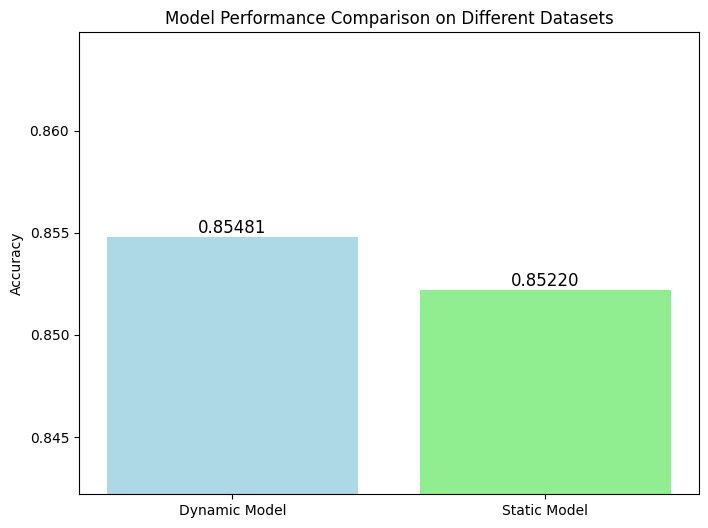

In [17]:
# calculate the average F1 score of dynamic and static models
avg_dynamic_f1 = sum(list_of_f1_dynamic_model) / len(list_of_f1_dynamic_model)
avg_static_f1 = sum(list_of_f1_static_model) / len(list_of_f1_static_model)

# Print the average F1 scores
print(f'Average F1 score of dynamic model = {avg_dynamic_f1}')
print(f'Average F1 score of static model = {avg_static_f1}')

# Show F1-scores comparison
plt.figure(figsize=(8, 6))
plt.bar(['Dynamic Model', 'Static Model'], [avg_dynamic_f1, avg_static_f1], color=['lightblue', 'lightgreen'])
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison on Different Datasets')
plt.ylim([min([avg_dynamic_f1, avg_static_f1]) - 0.01, max([avg_dynamic_f1, avg_static_f1]) + 0.01])

# Annotate the bars with their respective accuracy values
for i, v in enumerate([avg_dynamic_f1, avg_static_f1]):
    plt.text(i, v, f'{v:.5f}', ha='center', va='bottom', fontsize=12)

plt.show()

In [18]:
import pandas as pd

# Create a DataFrame
data = {
    'F1 Score': list_of_f1_dynamic_model + list_of_f1_static_model,
    'Model Type': ['Dynamic'] * len(list_of_f1_dynamic_model) + ['Static'] * len(list_of_f1_static_model)
}

df = pd.DataFrame(data)


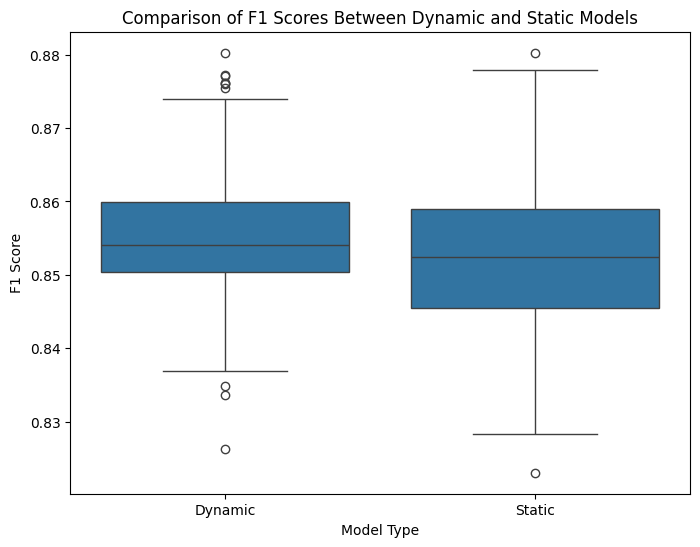

In [19]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Model Type', y='F1 Score', data=df)
plt.title('Comparison of F1 Scores Between Dynamic and Static Models')
plt.show()
